In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof

In [2]:
plt.style.use('ggplot')

In [3]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
region = 'global'

In [4]:
# -- Read regular V 
V = xr.open_dataset('/data/ysilvy/bin_TS/volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc')
V = V.histogram_so_thetao

In [5]:
# -- Apply temporal smoothing
V10 = V.rolling(time=10,center=True,keep_attrs=True,min_periods=1).mean()
V20 = V.rolling(time=20,center=True,keep_attrs=True,min_periods=1).mean()

## Time series one gridpoint 

Text(0.5, 1.0, 'S=33.61 T=10.10')

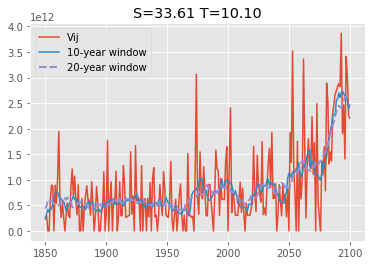

In [29]:
# -- Look at one gridpoint
S=33.6
T=10.1
Vij = V.sel(so_bin=S,thetao_bin=T,method='nearest')
Vsmooth1 = V10.sel(so_bin=S,thetao_bin=T,method='nearest')
Vsmooth2 = V20.sel(so_bin=S,thetao_bin=T,method='nearest')
plt.plot(np.arange(1850,2101),Vij,label='Vij')
plt.plot(np.arange(1850,2101),Vsmooth1,label='10-year window')
plt.plot(np.arange(1850,2101),Vsmooth2,label='20-year window',ls='--',lw=2)
plt.legend()
plt.title('S=%.2f T=%.2f' %(Vij.so_bin.data,Vij.thetao_bin.data))

## Plot anomaly 

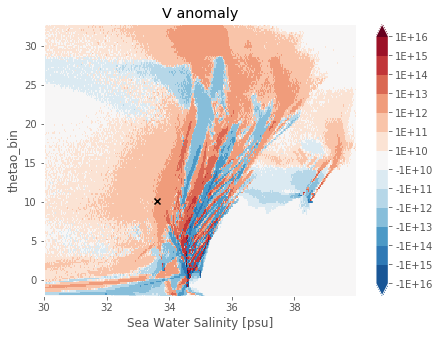

In [30]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

# Define anomaly = [2081-2100] - [1850-1899]
V_ano10 = V10.isel(time=slice(-20,-1)).mean(dim='time')-V10.isel(time=slice(0,50)).mean(dim='time')
V_ano20 = V20.isel(time=slice(-20,-1)).mean(dim='time')-V20.isel(time=slice(0,50)).mean(dim='time')
V_ano = V.isel(time=slice(-20,-1)).mean(dim='time')-V.isel(time=slice(0,50)).mean(dim='time')

levels = [-1.e16,-1.e15,-1.e14,-1.e13,-1.e12,-1.e11,-1.e10,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

# Anomaly
c=V_ano.T.plot(levels=levels,extend='both',add_colorbar=False)
cb = fig.colorbar(c,ax=ax,label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax.set_title('V anomaly');
plt.scatter(Vij.so_bin.data,Vij.thetao_bin.data,marker='x',color='black')

## EOF

In [31]:
def compute_eof(V):
    # -- Center and reduce data prior to performing EOF
    Vred = V - V.mean(dim='time')
    Vred = Vred/V.std(dim='time')
    
    # -- Perform EOF
    solver=Eof(Vred.stack(z=('so_bin', 'thetao_bin')))
    pcs = solver.pcs(npcs=3)
    eofs = solver.eofs(neofs=3)
    variance_frac = solver.varianceFraction()
    
    return Vred, solver, pcs, eofs, variance_frac

In [33]:
Vred, solver, pcs, eofs, variance_frac = compute_eof(V)
Vred1, solver1, pcs1, eofs1, variance_frac1 = compute_eof(V10)
Vred2, solver2, pcs2, eofs2, variance_frac2 = compute_eof(V20)

## Mode 1 

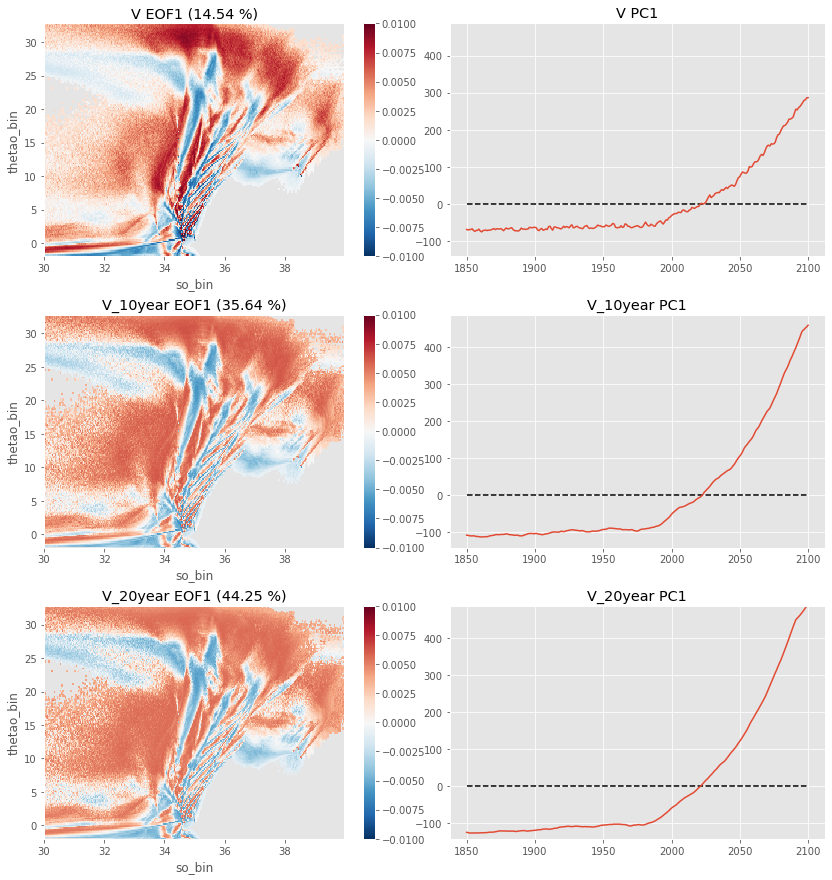

In [36]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var10 = variance_frac[0].data*100
var11 = variance_frac1[0].data*100
var12 = variance_frac2[0].data*100
eof10 = eofs[0,:].unstack('z')
eof11 = eofs1[0,:].unstack('z')
eof12 = eofs2[0,:].unstack('z')

vmin = -0.01 # vmin = np.min(np.array([eof10,eof11,eof12]))
vmax = 0.01 # vmax = np.max(np.array([eof10,eof11,eof12]))

c = eof10.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF1 ('+'%.2f '% Decimal(str(var10))+'%)')
ax[0,1].plot(time,pcs[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC1')
# ax[0,0].scatter(34.51,17.5,marker='x',color='black')

c = eof11.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('V_10year EOF1 ('+'%.2f '% Decimal(str(var11))+'%)')
ax[1,1].plot(time,pcs1[:,0])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('V_10year PC1')

c = eof12.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('V_20year EOF1 ('+'%.2f '% Decimal(str(var12))+'%)')
ax[2,1].plot(time,pcs2[:,0])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('V_20year PC1')

ylim = ax[1,1].get_ylim()
ax[0,1].set_ylim(ylim[0],ylim[1])
ax[2,1].set_ylim(ylim[0],ylim[1])

plt.subplots_adjust(hspace=0.25,wspace=0.08)

## Mode 2

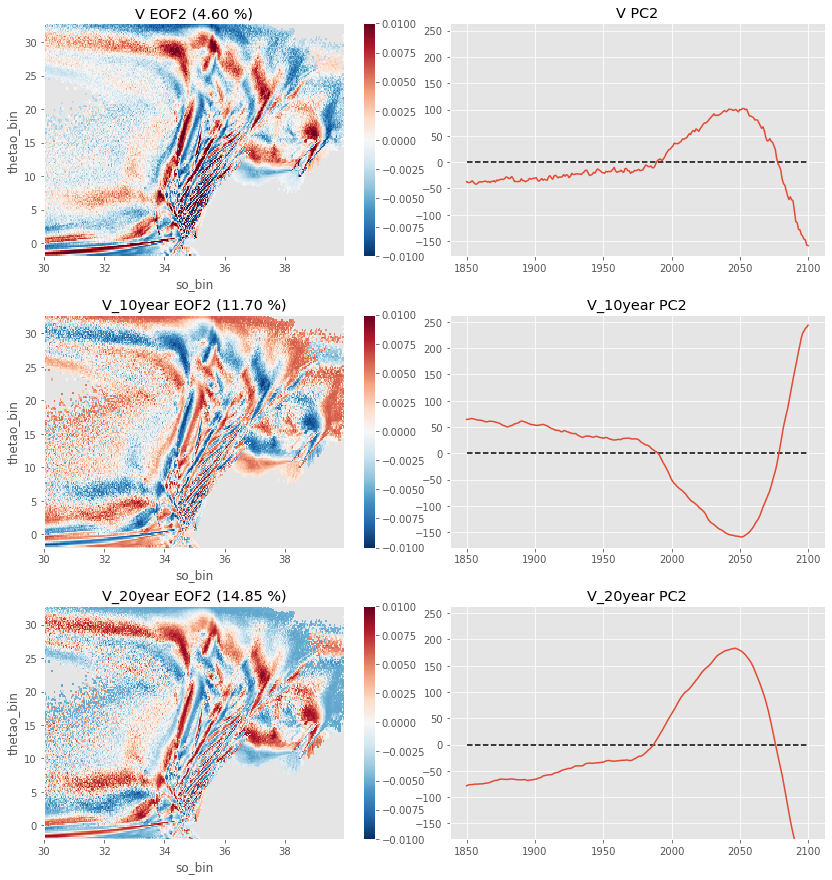

In [42]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var20 = variance_frac[1].data*100
var21 = variance_frac1[1].data*100
var22 = variance_frac2[1].data*100
eof20 = eofs[1,:].unstack('z')
eof21 = eofs1[1,:].unstack('z')
eof22 = eofs2[1,:].unstack('z')

vmin = -0.01 # vmin = np.min(np.array([eof20,eof21,eof22]))
vmax = 0.01 # vmax = np.max(np.array([eof20,eof21,eof22]))

c = eof20.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF2 ('+'%.2f '% Decimal(str(var20))+'%)')
ax[0,1].plot(time,pcs[:,1])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC2')

c = eof21.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('V_10year EOF2 ('+'%.2f '% Decimal(str(var21))+'%)')
ax[1,1].plot(time,pcs1[:,1])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('V_10year PC2')

c = eof22.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('V_20year EOF2 ('+'%.2f '% Decimal(str(var22))+'%)')
ax[2,1].plot(time,pcs2[:,1])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('V_20year PC2')

ylim = ax[1,1].get_ylim()
ax[0,1].set_ylim(ylim[0],ylim[1])
ax[2,1].set_ylim(ylim[0],ylim[1])

plt.subplots_adjust(hspace=0.25,wspace=0.08)

## Mode 3 

(-200, 200)

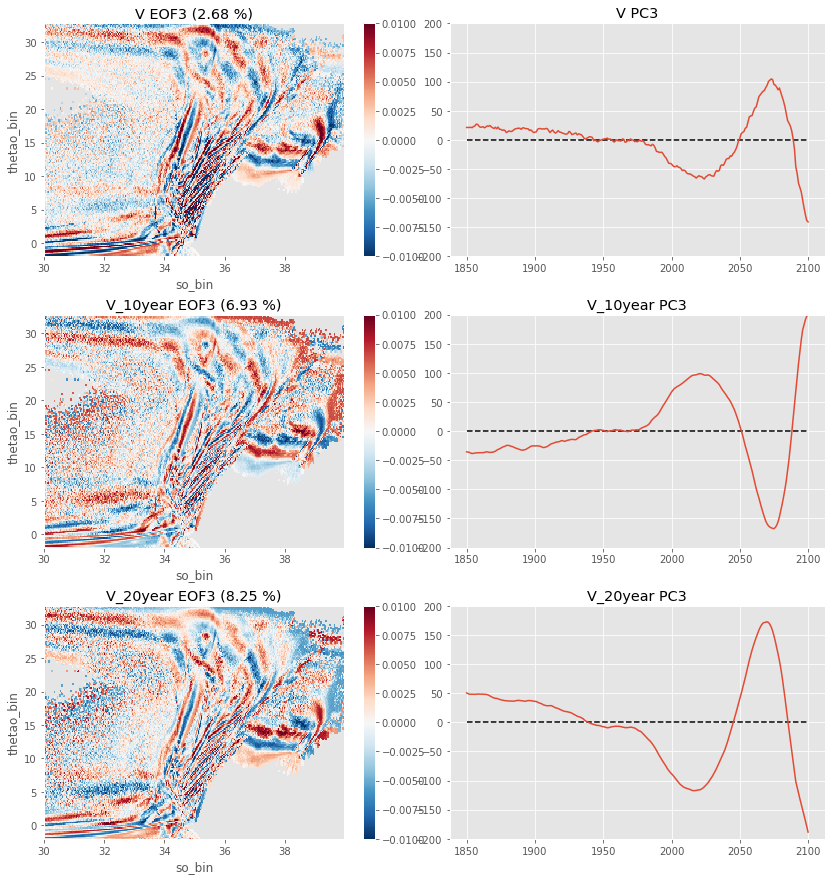

In [40]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var30 = variance_frac[2].data*100
var31 = variance_frac1[2].data*100
var32 = variance_frac2[2].data*100
eof30 = eofs[2,:].unstack('z')
eof31 = eofs1[2,:].unstack('z')
eof32 = eofs2[2,:].unstack('z')

vmin = -0.01
vmax = 0.01 

c = eof30.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF3 ('+'%.2f '% Decimal(str(var30))+'%)')
ax[0,1].plot(time,pcs[:,2])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC3')

c = eof31.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('V_10year EOF3 ('+'%.2f '% Decimal(str(var31))+'%)')
ax[1,1].plot(time,pcs1[:,2])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('V_10year PC3')

c = eof32.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('V_20year EOF3 ('+'%.2f '% Decimal(str(var32))+'%)')
ax[2,1].plot(time,pcs2[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('V_20year PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.08)
ax[0,1].set_ylim(-200,200)
ax[1,1].set_ylim(-200,200)
ax[2,1].set_ylim(-200,200)

## Variance 

(0, 0.05)

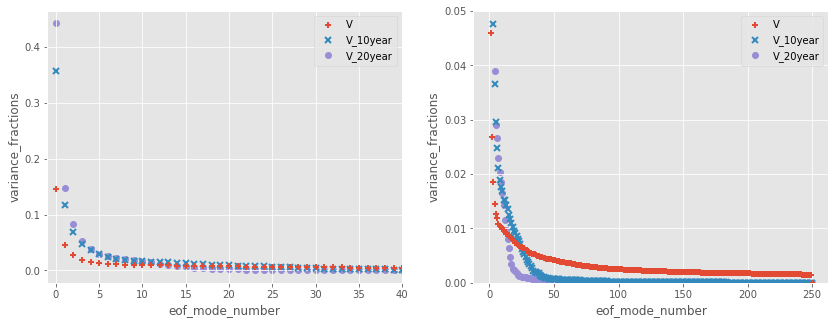

In [41]:
fig,ax=plt.subplots(ncols=2,figsize=(14,5))
for i in range(2):
    variance_frac.plot(ax=ax[i],marker='+',mew=2,linewidth=0,label='V',zorder=2)
    variance_frac1.plot(ax=ax[i],marker='x',mew=2,linewidth=0,label='V_10year',zorder=1)
    variance_frac2.plot(ax=ax[i],marker='o',mew=1,linewidth=0,label='V_20year',zorder=0)
    ax[i].legend();
ax[0].set_xlim([-1,40])
ax[1].set_ylim([0,0.05])